# Multi-level Regression

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
az.style.use('arviz-darkgrid')

In this notebook we demo how to perform a Bayesian multi-level regression.  
We'll use a multi-level dataset included with `statsmodels` containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). Since the weight of each pig is measured multiple times, we'll estimate a model that allows varying intercepts and slopes for time, for each pig.

### Load data

In [3]:
# Load up data from statsmodels
data = sm.datasets.get_rdataset('dietox', 'geepack').data
data.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


### Model

$$
Y_i = \beta_{0, i} + \beta_{1, i} X + \epsilon_i
$$

with 

$\beta_{0, i} = \beta_0 + \alpha_{0, i}$  
$\beta_{1, i} = \beta_1 + \alpha_{1, i}$  


where $\beta_0$ and $\beta_1$ are usual fixed intercept and slope you find in a linear regression. $\alpha_{0, i}$
and $\alpha_{1, i}$ are the random components for the pig $i$, influencing the intercept and the slope respectively. Finally $\epsilon_i$ is the random error we always see in this type of models.

We use the formula syntax to specify the model. The first argument passed to the `.fit()` call describes the
fixed components and the second named argument, `random`, describes the random components. In order to use a model that allows varying intercepts and slopes for the predictor `'Time'` we need to include `'Time'` as a fixed effect and write `'Time|Pig'` in the random argument. The latter means each pig as a different intercept and `'Time'` slope. If we only wanted different intercepts, we would have written `random='1|Pig'`.

In [4]:
model = bmb.Model(data)
results = model.fit('Weight ~ Time', random='Time|Pig')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Weight_sigma, Time|Pig_offset, Time|Pig_sigma, 1|Pig_offset, 1|Pig_sigma, Time, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


Since we have not specified prior distributions for the parameters in the model, Bambi has chosen sensible defaults for us. We can explore these priors through samples generated from them with a call to `Model.plot_priors()`, which plots a kernel density estimate for each prior.

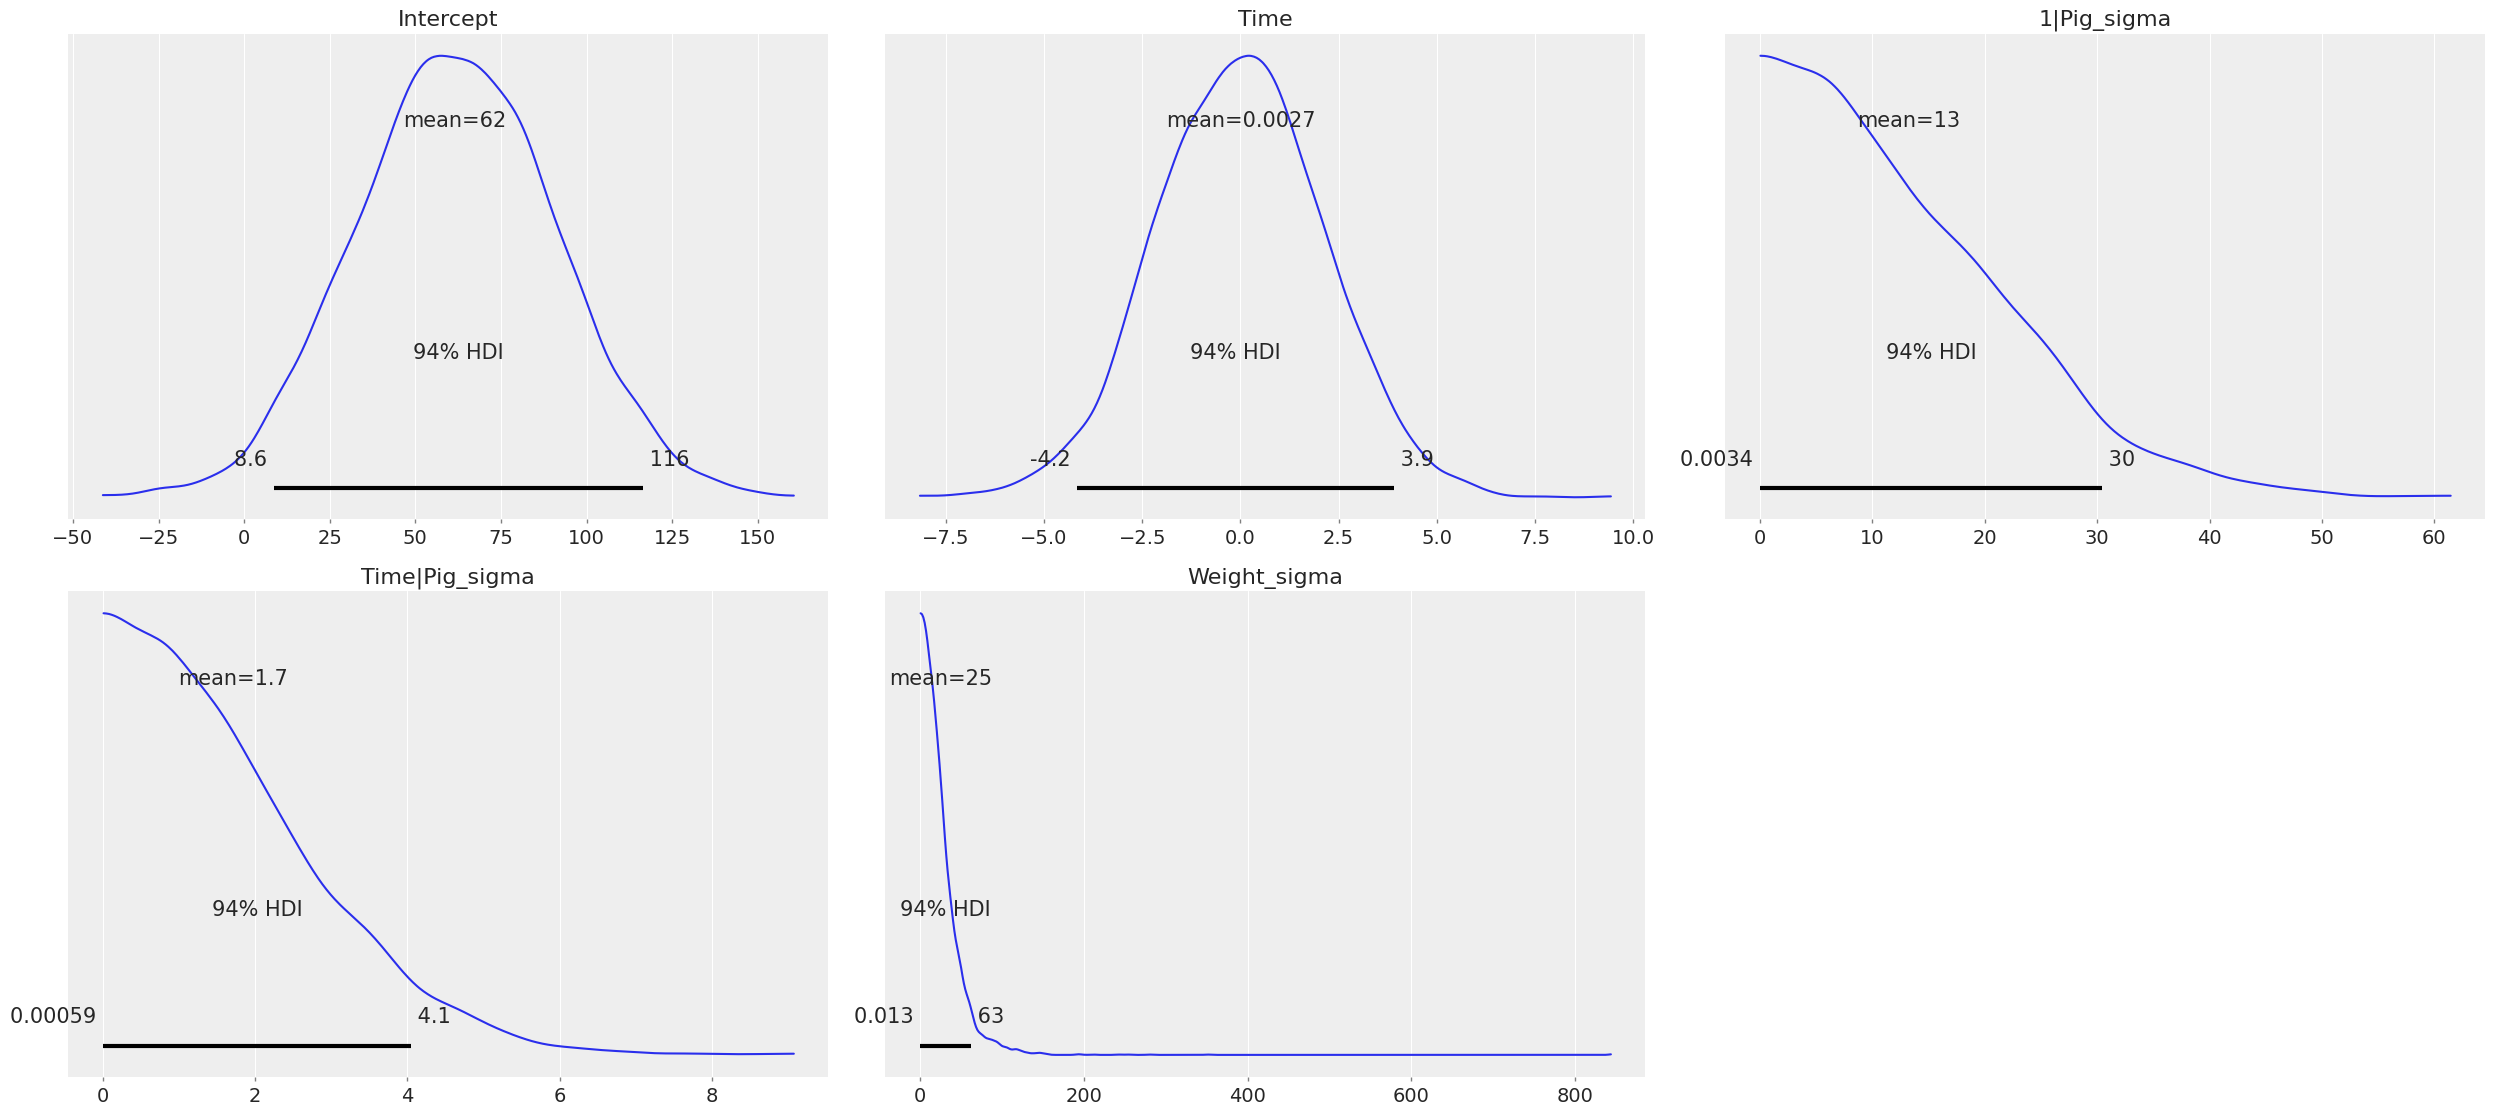

In [5]:
model.plot_priors(var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'Weight_sigma']);

Now we are ready to check the results. Using `az.plot_trace()` we get traceplots that show the values sampled from the posteriors and density estimates that gives us an idea of the shape of the posterior distribution of our parameters.

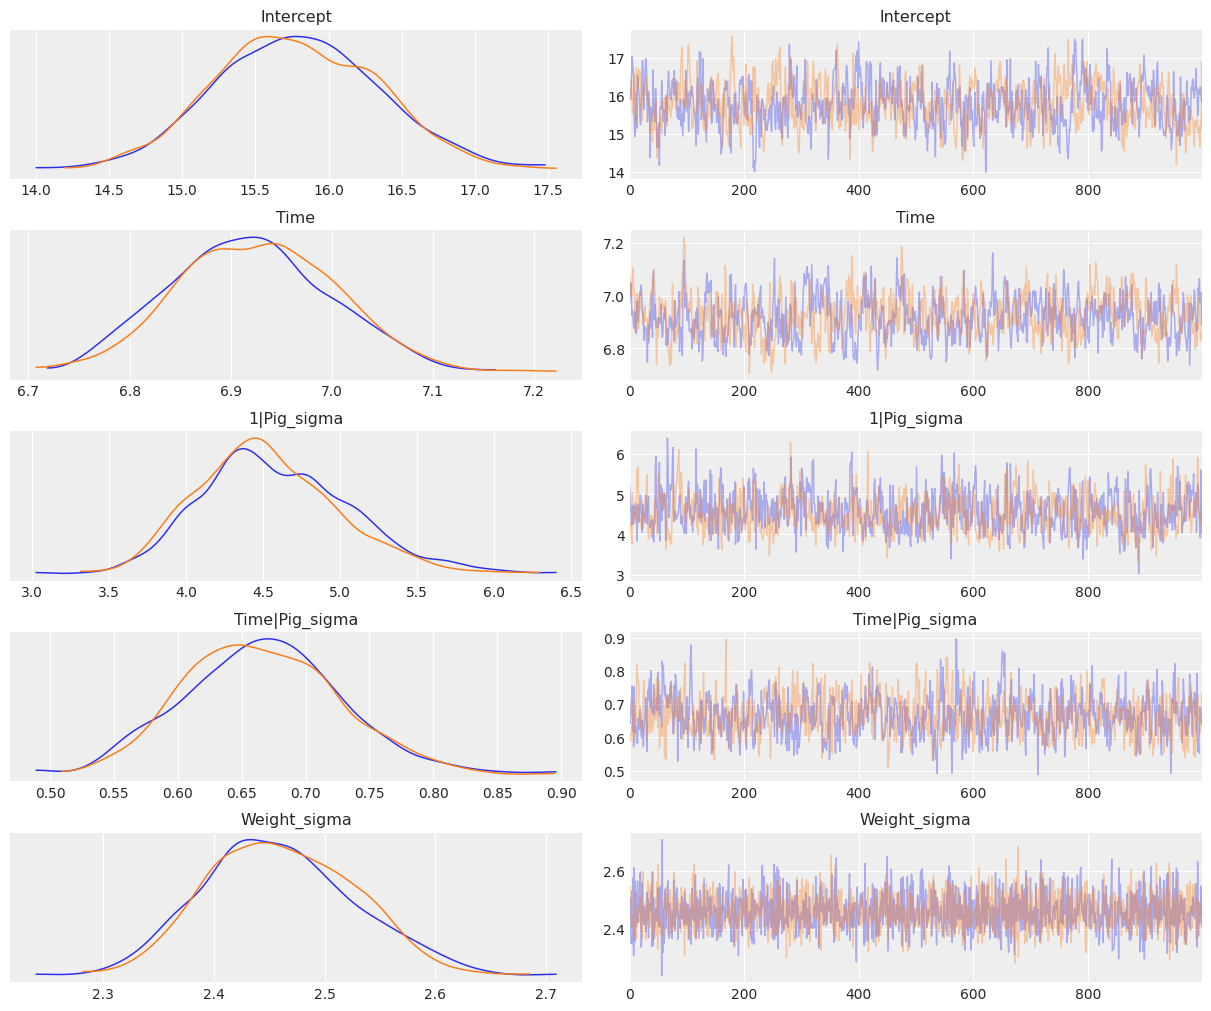

In [6]:
# Plot posteriors
az.plot_trace(
    results,
    var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'Weight_sigma']
);

The plots generated by `az.plot_trace()` are enough to be confident that the sampler did a good job and conclude about plausible values for the distribution of each parameter in the model. But if we want to, and is a good idea to do it, we can get umerical summaries for the posteriors with `az.summary()`. 

In [7]:
az.summary(results, var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'Weight_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,15.783,0.574,14.828,16.985,0.031,0.022,345.0,344.0,346.0,864.0,1.0
Time,6.923,0.079,6.772,7.062,0.004,0.003,378.0,378.0,381.0,786.0,1.0
1|Pig_sigma,4.557,0.468,3.745,5.458,0.021,0.015,476.0,472.0,499.0,1148.0,1.0
Time|Pig_sigma,0.666,0.061,0.553,0.776,0.002,0.002,697.0,695.0,698.0,1204.0,1.0
Weight_sigma,2.460,0.066,2.342,2.582,0.001,0.001,3190.0,3183.0,3175.0,1516.0,1.0


### Estimated regression line

Here we'll visualize the regression equations we have sampled for a particular pig and then we'll compare
the mean regression equation for all the 72 pigs in the dataset.  

In the following plot we can see the 2000 linear regressions we have sampled for the pig '4601'.  
The random slopes explain the funnel shape. The mean regression line is plotted in black and the 
observed weights for this pig are marked by the blue dots.

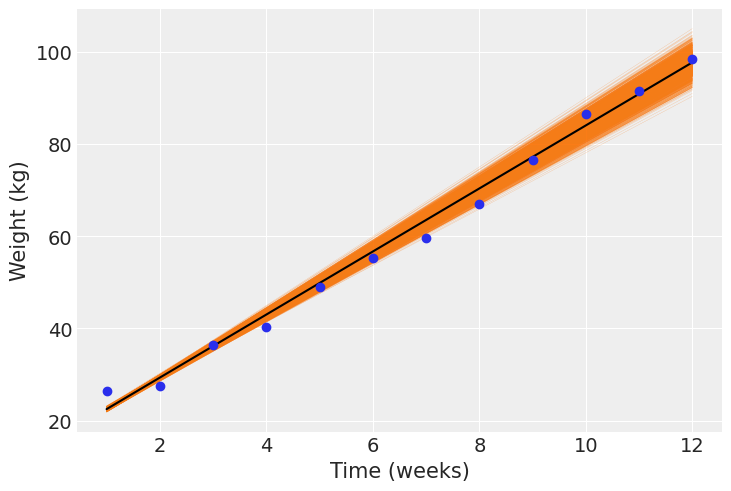

In [8]:
# The ID of the first pig is '4601'
data_0 = data[data['Pig'] == 4601][['Time', 'Weight']]
time = np.array([1, 12])
intercept_fixed = results.posterior['Intercept'].mean()
slope_fixed = results.posterior['Time'].mean()
intercept_random_0 = results.posterior['1|Pig_offset'].stack(draws=("chain", "draw"))[0]
slope_random_0 = results.posterior['Time|Pig'].stack(draws=("chain", "draw"))[0]
a = (intercept_fixed + intercept_random_0).values
b = (slope_fixed + slope_random_0).values

plt.plot(time, a + b * time[:,None], color="C1", lw=0.1, zorder=1)
plt.plot(time, a.mean() + b.mean() * time, color="black", zorder=1)
plt.scatter(data_0['Time'], data_0['Weight'], zorder=2)
plt.ylabel('Weight (kg)')
plt.xlabel('Time (weeks)');

Next, we calculate the mean regression line for each pig and show them together in one plot.

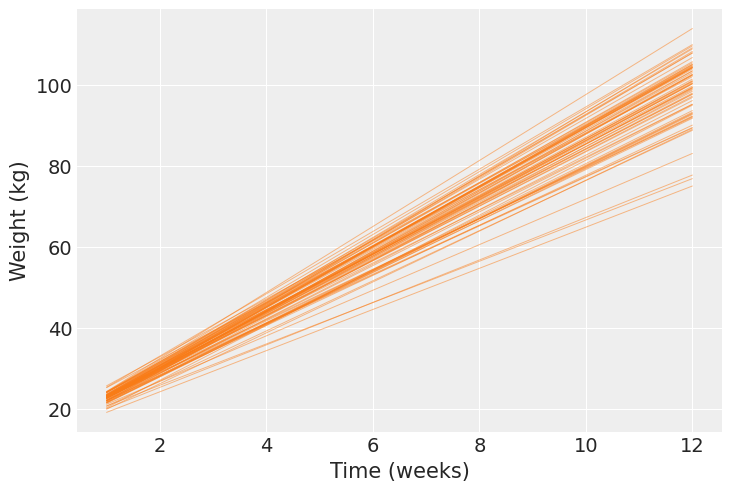

In [9]:
intercept_random = results.posterior['1|Pig_offset'].stack(draws=("chain", "draw"))
slope_random = results.posterior['Time|Pig'].stack(draws=("chain", "draw"))
a = (intercept_fixed + intercept_random.mean(axis=1)).values
b = (slope_fixed + slope_random.mean(axis=1)).values
plt.plot(time, a + b * time[:,None], color="C1", alpha=0.5, lw=0.7)
plt.ylabel('Weight (kg)')
plt.xlabel('Time (weeks)');

We can get credible interval plots with ArviZ. Here the line indicates a 94% credible interval calculated as higher posterior density, the thicker line represents the interquartile range and the dot is the median. We can quickly note two things:

* The uncertainty about the intercept estimate is much higher than the uncertainty about the 'Time' slope.
* The credible interval for 'Time' is far away from 0, so we can be confident there's a positive relationship
the 'Weight' of the pigs and 'Time'.  

We're not making any great discovering by stating that as time passes we expect the pigs to weight more, but this very simple example can be used as a starting point in applications where the relationship between the variables
is not that clear beforehand.

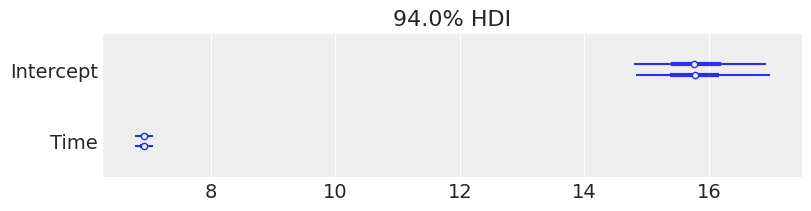

In [10]:
az.plot_forest(
    results,
    var_names=list(map(str, model.backend.model.vars[:2])), # or just ['Intercept', 'Time']
    figsize=(8, 2),
);

We can also plot the posterior overlayed with a region of practical equivalence (ROPE). This region indicates a range of parameter values that are considered to be practically equivalent to some reference value of interest to the particular application, for example 0. In the following plot we can see that all our posterior distributions fall outside of this range.

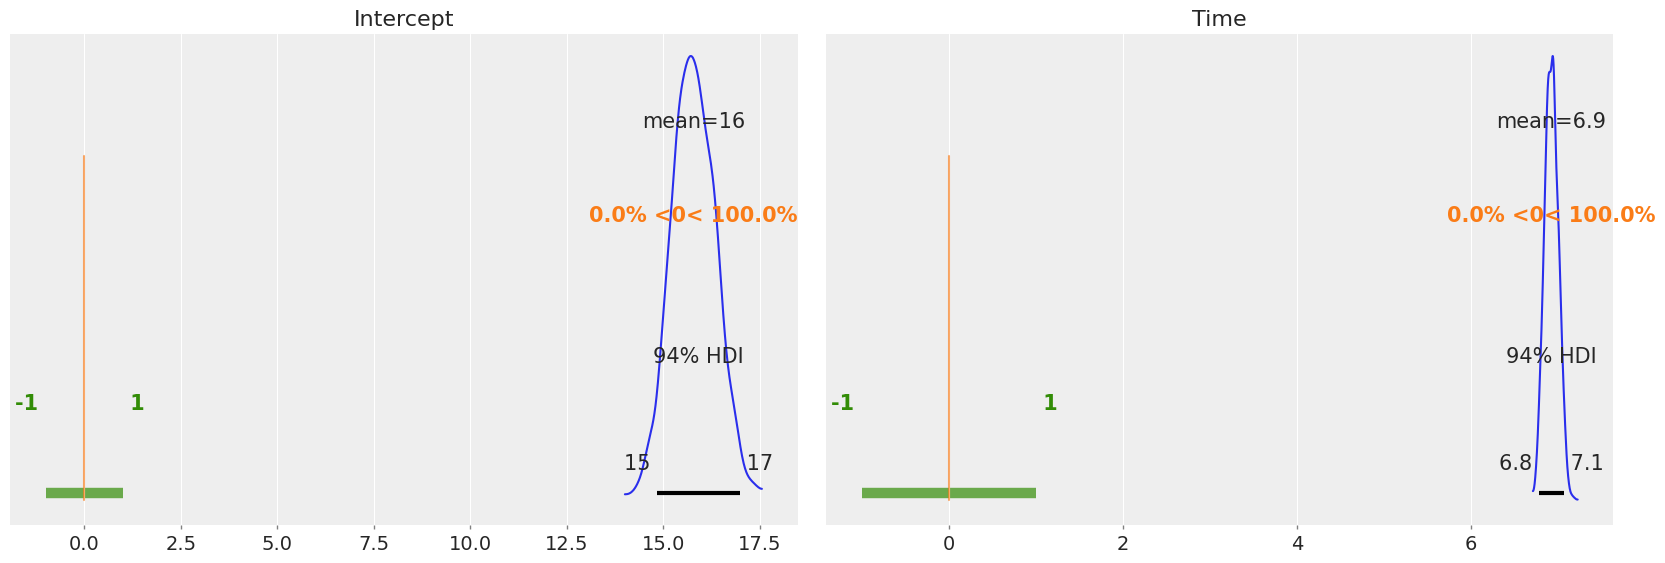

In [11]:
az.plot_posterior(
    results,
    var_names=list(map(str, model.backend.model.vars[:2])),
    ref_val=0,
    rope=[-1, 1]
);